# Update:

- Datum u druhé main function by mělo být ok, hlavní point je asi teď na interface. Nějak do ní zakomponovat to stock info a kalendář (to by bylo top). Interface zkus tkinter nebo Pyqt. Vůbec jsem se nedostal k tomu, jak to funguje.
- V modelu není arima protože mi to házelo error (pardon), ale klidně ji přidej (nebo jiný model), to by asi bylo fajn.


- Já pak přidám callout s těmi dny, že tam jsou víkendy, ale to není ted prio
- Ten model jako takový je už asi v pohodě, takže pak přidat věci okolo, vytvořit soubory a definované funkce hodit do souborů


No pressure, na zbytku budu pracovat zítra a pozítří (+ dle feedbacku)



Import and install neccesary libraries

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

Stock overview

In [4]:
stock_info = {
    'AAPL': 'Apple Inc.',
    'MSFT': 'Microsoft Corporation',
    'GOOGL': 'Alphabet Inc. (Google)',
    'AMZN': 'Amazon.com Inc.',
    'FB': 'Meta Platforms Inc. (Facebook)',
    'TSLA': 'Tesla Inc.',
    'JPM': 'JPMorgan Chase & Co.',
    'JNJ': 'Johnson & Johnson',
    'V': 'Visa Inc.',
    'PG': 'Procter & Gamble Co.',
    'NVDA': 'NVIDIA Corporation',
    'BRK-B': 'Berkshire Hathaway Inc.',
    'UNH': 'UnitedHealth Group Incorporated',
    'DIS': 'The Walt Disney Company',
    'MA': 'Mastercard Incorporated',
    'PYPL': 'PayPal Holdings Inc.',
    'HD': 'The Home Depot Inc.',
    'CMCSA': 'Comcast Corporation',
    'VZ': 'Verizon Communications Inc.',
    'INTC': 'Intel Corporation',
    'T': 'AT&T Inc.',
    'PFE': 'Pfizer Inc.',
    'MRK': 'Merck & Co. Inc.',
    'NFLX': 'Netflix Inc.',
    'PEP': 'PepsiCo Inc.',
    'WMT': 'Walmart Inc.',
    'CSCO': 'Cisco Systems Inc.',
    'ADBE': 'Adobe Inc.',
    'BAC': 'Bank of America Corporation',
    'KO': 'The Coca-Cola Company',
    'XOM': 'Exxon Mobil Corporation',
    'GOOG': 'Alphabet Inc. (Google)',
    'CRM': 'Salesforce.com Inc.',
    'ABBV': 'AbbVie Inc.',
    'NKE': 'NIKE Inc.',
    'ABT': 'Abbott Laboratories',
    'MO': 'Altria Group Inc.',
    'LLY': 'Eli Lilly and Company',
    'PEP': 'PepsiCo Inc.',
    'CVX': 'Chevron Corporation',
    'BA': 'The Boeing Company',
    'CAT': 'Caterpillar Inc.',
    'COST': 'Costco Wholesale Corporation',
}



Gather Historical Stock Data

In [5]:
# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

Calculate Daily Returns and Simple Moving Average (SMA) and Exponential Moving Average (EMA)

In [6]:
# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data = stock_data.copy()  # Create a copy of the DataFrame to work on
    stock_data.loc[:, 'SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data.loc[:, 'EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

Prepare Features and Target

In [7]:
# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

Train and Evaluate Models - Linear Regression, Random Forest and ARIMA
- best model is based on the MSE and if they have the same one (very rare but happened once), we will choose the one with higher R2

In [8]:
# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {name}")
    
    print(f"Best MSE: {best_mse}")
    
    return best_model



Visualize Predictions

In [9]:
# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, stock_symbol):
    plt.style.use('dark_background')  # Set the style to dark background
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create the bar plot
    bars = ax.bar(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', color=np.random.rand(3,), edgecolor='grey')

    # Add title and labels
    ax.set_title(f'{stock_symbol} Predicted Stock Returns', color='white')
    ax.set_xlabel('Date', color='white')
    ax.set_ylabel('Predicted Returns', color='white')

    # Set the tick parameters to be white
    ax.tick_params(axis='both', colors='white')

    # Add grid and set its color to mild dark grey
    ax.grid(True, color='#555555')

    # Add legend with white text
    ax.legend(loc='upper left', frameon=True, facecolor='#363636', edgecolor='white', framealpha=1, fontsize=12, labelcolor='white')

    # Outline in mild dark grey
    for spine in ax.spines.values():
        spine.set_edgecolor('#555555')

    plt.show()


Main Function

Tady je fixed enddate - raději to tu nechávám

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best MSE: 0.0035387088737192252


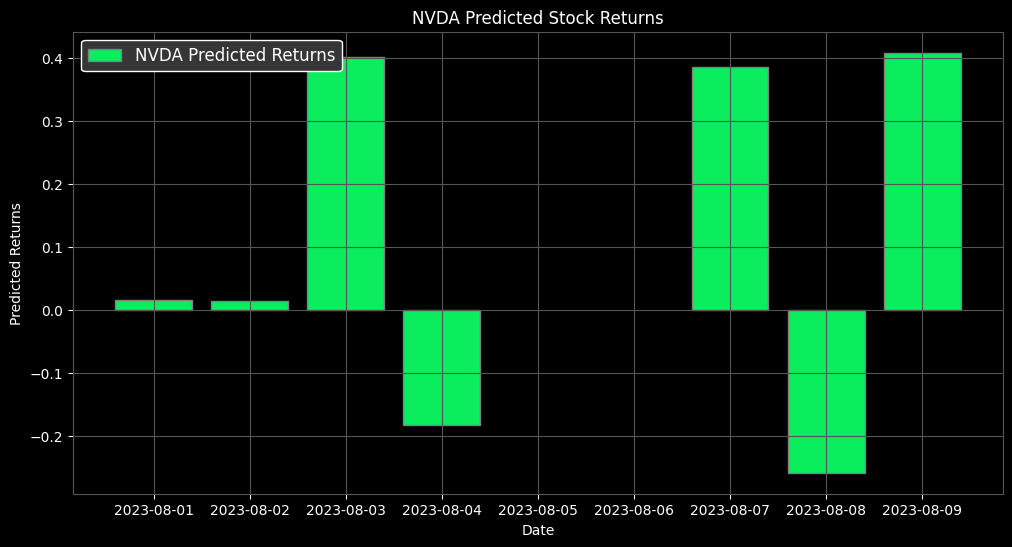

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best MSE: 0.00023354851585431646


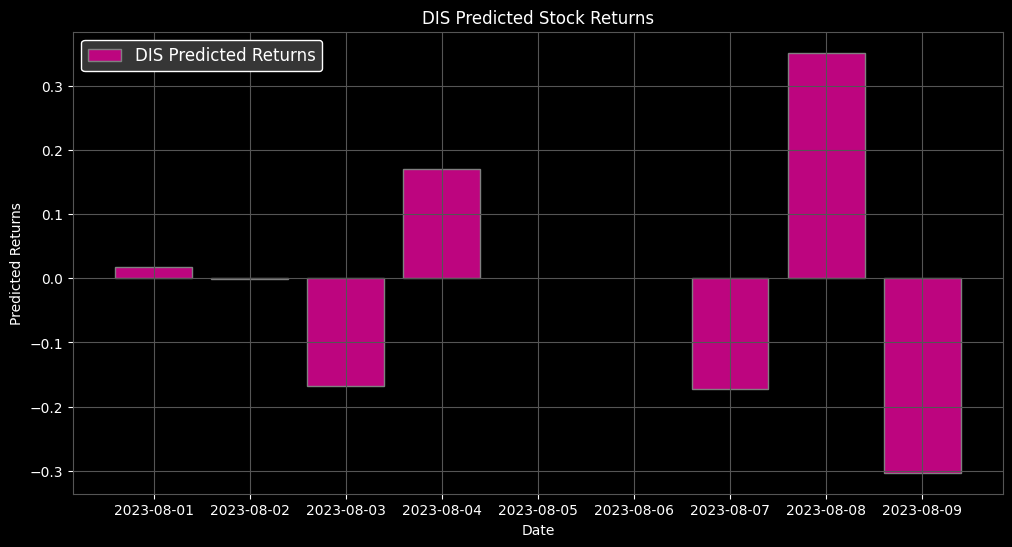

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.00014198133895278596


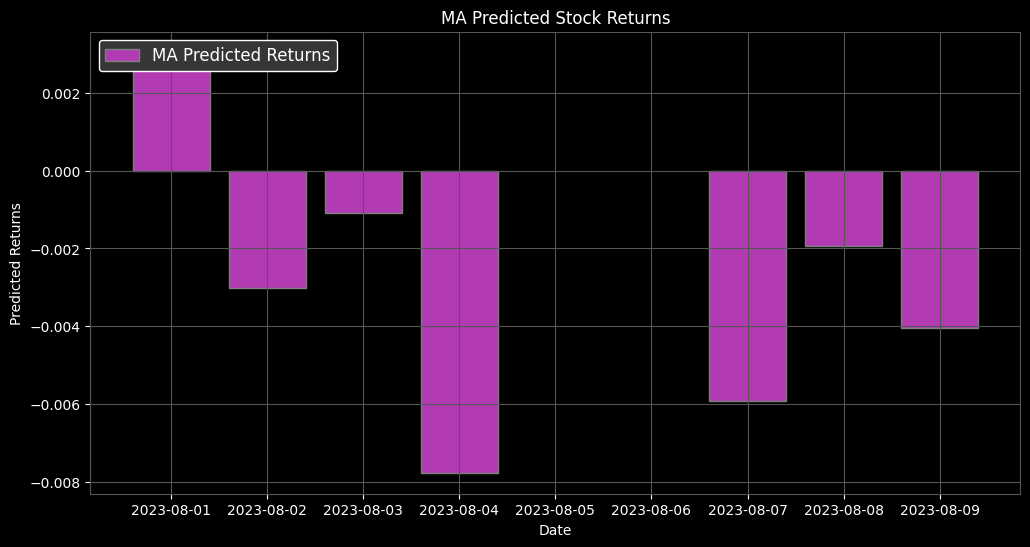

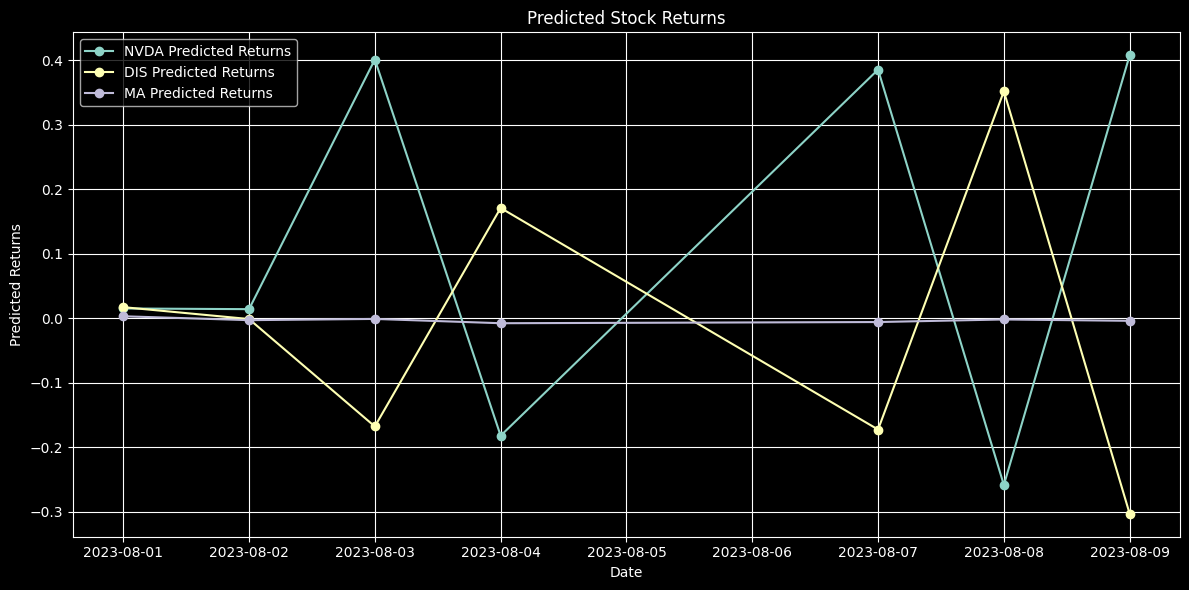

In [10]:
# Main Function
if __name__ == "__main__":
    stock_symbols = []
    for i in range(3):
        stock_symbol = input(f"Enter stock symbol {i+1} (or press Enter to stop): ")
        if not stock_symbol:
            break
        stock_symbols.append(stock_symbol)
    
    if not stock_symbols:
        print("No stock symbols provided. Exiting.")
        exit()

    start_date = input("Enter the start date (YYYY-MM-DD): ")
    num_days = input("Enter the number of days to forecast (1-60): ")

    try:
        num_days = int(num_days)
        if not (1 <= num_days <= 60):
            print("Invalid number of days. Please enter a value between 1 and 60.")
            exit()
    except ValueError:
        print("Invalid number of days. Please enter a valid number.")
        exit()

    end_date = "2023-08-01"

    predicted_returns_dict = {}

    for stock_symbol in stock_symbols:
        stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
        
        if len(stock_data) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        daily_returns_data = calculate_daily_returns(stock_data)
        
        window = 20
        stock_data = calculate_sma_ema(daily_returns_data, window)
        
        X, y = prepare_data(stock_data, num_days)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
        
        last_week_data = X_test[-1].reshape(1, -1)
        
        predicted_returns = []

        for i in range(num_days):
            prediction = best_model.predict(last_week_data)
            predicted_returns.append(prediction[0])
            new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
            last_week_data = np.roll(last_week_data, -3)
            last_week_data[0, -3:] = new_data_point

        predicted_returns_dict[stock_symbol] = predicted_returns

        prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
        
        visualize_predictions(predicted_returns, prediction_dates, stock_symbol)

    plt.figure(figsize=(12, 6))

    for stock_symbol, predicted_returns in predicted_returns_dict.items():
        plt.plot(prediction_dates, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

    plt.title('Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

TADY UŽ TO FUNGUJE, STARTDATE JSEM DAL AŽ NA 2010, ALE HODÍ TO ERROR, KDYŽ VYBEREŠ ENDDATE PŘED STARTDATE. Navíc je trochu dementní, že vybereš nejdřív number of days a pak kdy chceš skončit, ale co, output funguje. (jsem línej mazat tu část s capslockem a přepisovat)

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best MSE: 0.00040682629291216495


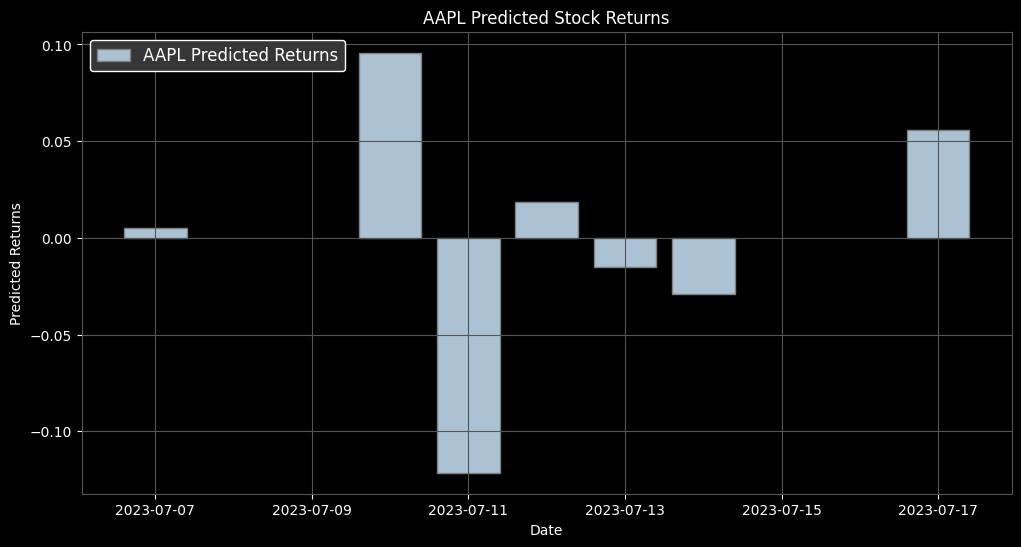

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.0012643265571540146


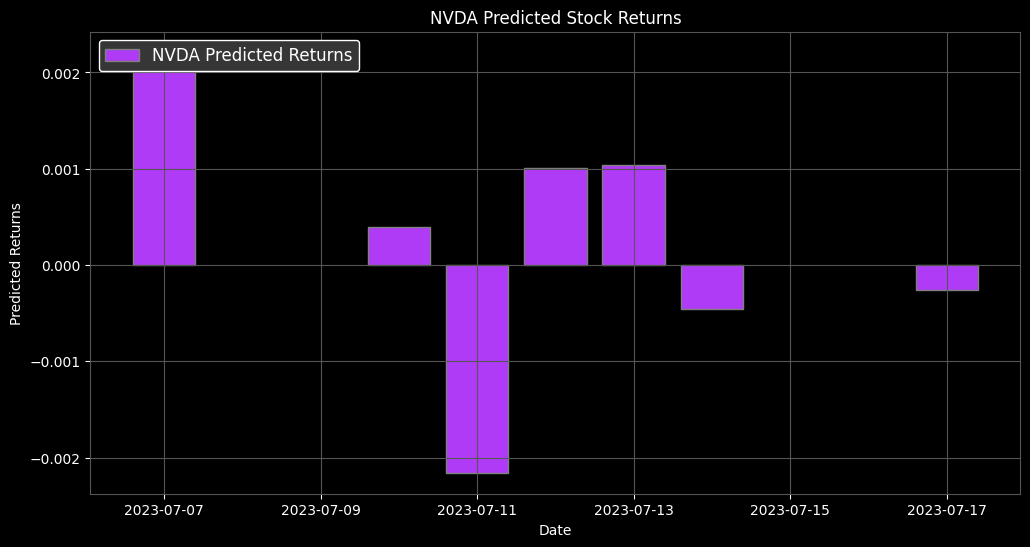

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best MSE: 0.000379806869643895


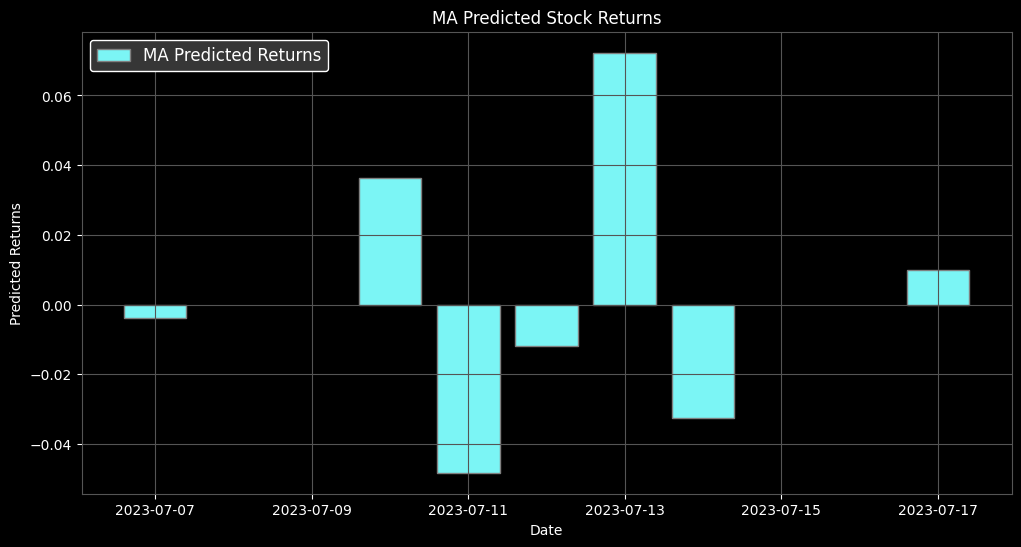

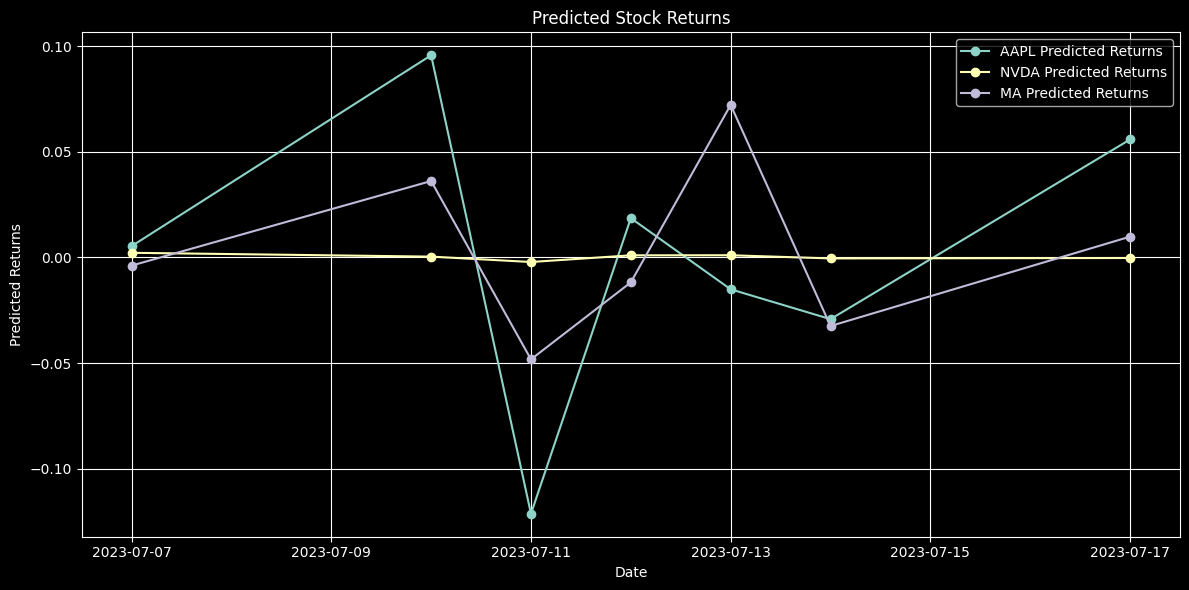

In [11]:
if __name__ == "__main__":
    stock_symbols = []
    for i in range(3):
        stock_symbol = input(f"Enter stock symbol {i+1} (or press Enter to stop): ")
        if not stock_symbol:
            break
        stock_symbols.append(stock_symbol)
    
    if not stock_symbols:
        print("No stock symbols provided. Exiting.")
        exit()

    
    num_days = input("Enter the number of days to forecast (1-60): ")
    end_date = input("Enter the start date (YYYY-MM-DD): ")
    
    try:
        num_days = int(num_days)
        if not (1 <= num_days <= 60):
            print("Invalid number of days. Please enter a value between 1 and 60.")
            exit()
    except ValueError:
        print("Invalid number of days. Please enter a valid number.")
        exit()

    start_date = "2010-01-01"

    predicted_returns_dict = {}

    for stock_symbol in stock_symbols:
        stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
        
        if len(stock_data) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        daily_returns_data = calculate_daily_returns(stock_data)
        
        window = 20
        stock_data = calculate_sma_ema(daily_returns_data, window)
        
        X, y = prepare_data(stock_data, num_days)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
        
        last_week_data = X_test[-1].reshape(1, -1)
        
        predicted_returns = []

        for i in range(num_days):
            prediction = best_model.predict(last_week_data)
            predicted_returns.append(prediction[0])
            new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
            last_week_data = np.roll(last_week_data, -3)
            last_week_data[0, -3:] = new_data_point

        last_date_in_data = stock_data.index[-1]
        prediction_dates = pd.date_range(start=last_date_in_data, periods=num_days+1, freq='B')[1:]  # Skip the first date to start from the next business day
        
        predicted_returns_dict[stock_symbol] = predicted_returns

        visualize_predictions(predicted_returns, prediction_dates, stock_symbol)

    plt.figure(figsize=(12, 6))

    for stock_symbol, predicted_returns in predicted_returns_dict.items():
        plt.plot(prediction_dates, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

    plt.title('Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Interface input sample code
- mně to nefunguje, otevře se mi python launcher a mám černou obrazovku, ale u tebe to třeba půjde

Main Function - output

Tady je snaha o to ziskat nejake akumulovane info k daily stock returns, ze cim vice by se ten model "run", tim vice informaci ohledne returns bychom dostali a vse by se pridavalo do tohodle histogramu

Tohle mi pls nemaž, já si s tím ještě pohraju a opticky to vypadá, že toho máme víc xd

Data not cleared.


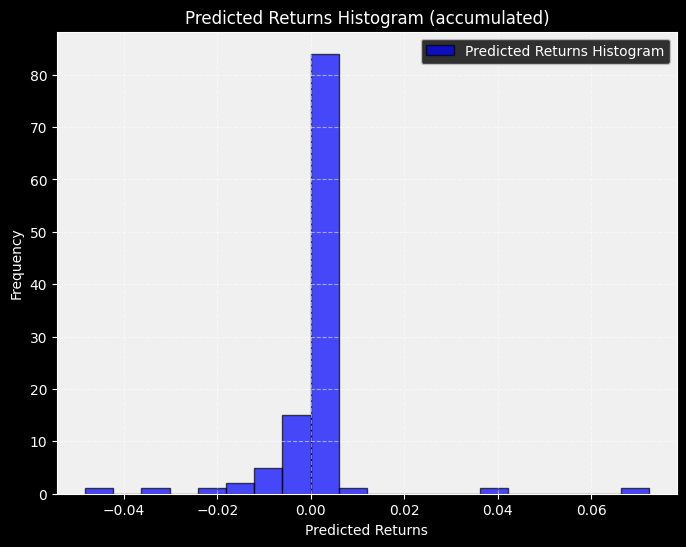

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to visualize the frequency histogram of predicted returns
def visualize_histogram(predicted_returns):
    plt.figure(figsize=(8, 6))

    # Calculate and plot the frequency histogram of predicted returns
    hist, bins, _ = plt.hist(
        predicted_returns, 
        bins=20, 
        alpha=0.7, 
        color='blue', 
        edgecolor='black',  # Add black outline
        label='Predicted Returns Histogram'
    )
    
    # Customize plot appearance
    plt.xlabel('Predicted Returns')
    plt.ylabel('Frequency')
    plt.title('Predicted Returns Histogram (accumulated)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)  # Add gridlines
    
    # Set a darker background color
    ax = plt.gca()
    ax.set_facecolor('#F0F0F0')  # Light gray background
    
    # Show the histogram
    plt.show()


# Function to save and load accumulated predicted returns
def save_accumulated_returns(filename, predicted_returns):
    with open(filename, 'a') as file:
        np.savetxt(file, predicted_returns, delimiter=',')

def load_accumulated_returns(filename):
    try:
        return np.genfromtxt(filename, delimiter=',').tolist()
    except FileNotFoundError:
        return []

# Function to clear accumulated predicted returns
def clear_accumulated_returns(filename):
    choice = input("Do you want to clear the accumulated data? (y/n): ").strip().lower()
    if choice == 'y':
        with open(filename, 'w') as file:
            file.write('')
        print("Data cleared.")
        return True
    elif choice == 'n':
        print("Data not cleared.")
        return False
    else:
        print("Invalid choice. Please choose 'y' to clear or 'n' to cancel.")
        return False

# Main Function
if __name__ == "__main__":
    # Example: Generate some sample predicted returns data (replace with your data)
    predicted_returns_example = predicted_returns

    # Specify the filename for storing accumulated predicted returns
    filename = 'predicted_returns.csv'

    # Check if the file exists and if you want to clear the data
    if not predicted_returns_example:
        print("No predicted returns data to accumulate.")
    else:
        if not os.path.exists(filename):
            print("No existing data file found.")
        else:
            clear_choice = clear_accumulated_returns(filename)
            if clear_choice or not clear_choice:  # Check if data is cleared or 'n' is chosen
                # Load previously accumulated predicted returns
                predicted_returns_accumulated = load_accumulated_returns(filename)

                # Accumulate the predicted returns for later analysis
                predicted_returns_accumulated.extend(predicted_returns_example)

                # Save the accumulated predicted returns
                save_accumulated_returns(filename, predicted_returns_accumulated)

                # Visualize the histogram of accumulated predicted returns
                visualize_histogram(predicted_returns_accumulated)


-----------------------------------------------------
------------------------------------------------------

**# Backup**

FINAL CODE
- problemky
    - neda se zmenit datum
    - neco jineho nez tyden nefunguje
    - foolproof stocks ktere nejsou v dictionary
    - neda se odhadovat pro data dopredu


    - Trochu si pohrát s interfacem
        - možnost více než 3 stocks?
        - drop-down menu by bylo top
        - napsat pár error kódů co se posralo
        - double check funkce a názvy, aby to nebylo defaultní a nevypadalo to blbě

No stock symbols provided. Exiting.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Invalid number of days. Please enter a valid number.


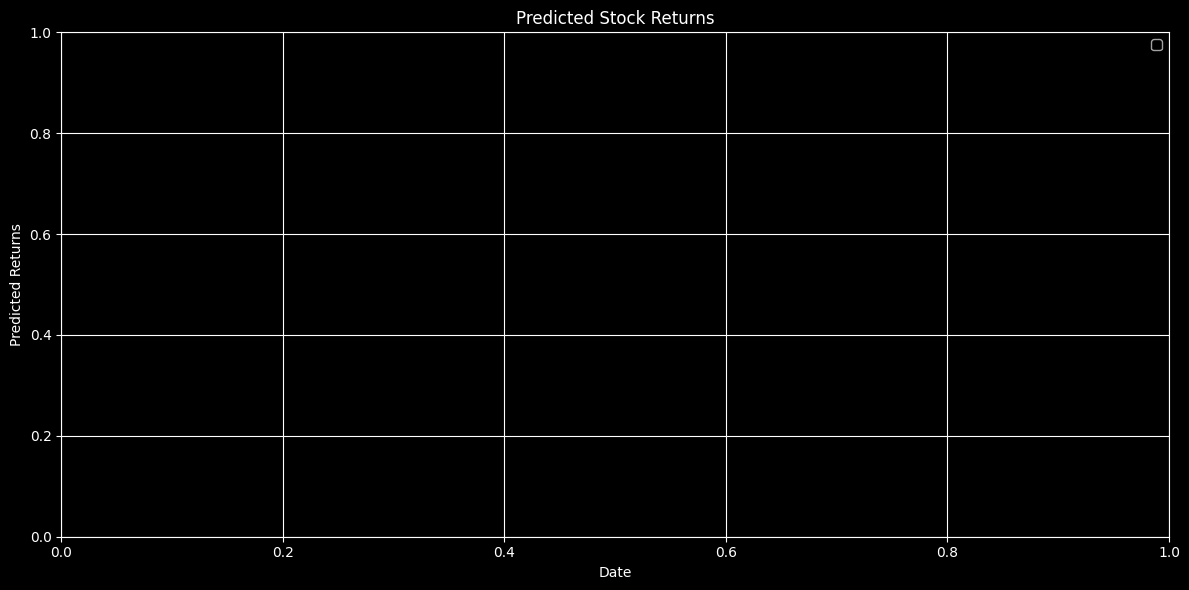

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data = stock_data.copy()  # Create a copy of the DataFrame to work on
    stock_data.loc[:, 'SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data.loc[:, 'EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()


# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {name}")
    
    print(f"Best MSE: {best_mse}")
    
    return best_model

# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, stock_symbol):
    plt.figure(figsize=(12, 6))
    plt.bar(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', color=np.random.rand(3,))
    plt.title(f'{stock_symbol} Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)

# ... (rest of your code above)

# Main Function
if __name__ == "__main__":
    stock_symbols = []
    for i in range(3):
        stock_symbol = input(f"Enter stock symbol {i+1} (or press Enter to stop): ")
        if not stock_symbol:
            break
        stock_symbols.append(stock_symbol)
    
    if not stock_symbols:
        print("No stock symbols provided. Exiting.")
        exit()

    start_date = input("Enter the start date (YYYY-MM-DD): ")
    num_days = input("Enter the number of days to forecast (1-60): ")

    try:
        num_days = int(num_days)
        if not (1 <= num_days <= 60):
            print("Invalid number of days. Please enter a value between 1 and 60.")
            exit()
    except ValueError:
        print("Invalid number of days. Please enter a valid number.")
        exit()
        
    end_date = "2023-08-01"

    predicted_returns_dict = {}

    for stock_symbol in stock_symbols:
        stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
        print(f"Fetched {len(stock_data)} data points for {stock_symbol} from {start_date} to {end_date}.")
        
        if len(stock_data) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        daily_returns_data = calculate_daily_returns(stock_data)
        
        window = 20
        stock_data = calculate_sma_ema(daily_returns_data, window)
        
        X, y = prepare_data(stock_data, num_days)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
        
        last_week_data = X_test[-1].reshape(1, -1)
        
        predicted_returns = []

        for i in range(num_days):
            prediction = best_model.predict(last_week_data)
            predicted_returns.append(prediction[0])
            new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
            last_week_data = np.roll(last_week_data, -3)
            last_week_data[0, -3:] = new_data_point

        predicted_returns_dict[stock_symbol] = predicted_returns

        prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
        
        visualize_predictions(predicted_returns, prediction_dates, stock_symbol)

    plt.figure(figsize=(12, 6))

    for stock_symbol, predicted_returns in predicted_returns_dict.items():
        plt.plot(prediction_dates, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

    plt.title('Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.00047480701500059993
[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best MSE: 0.0004470749939250572


NameError: name 'predicted_returns_dict' is not defined

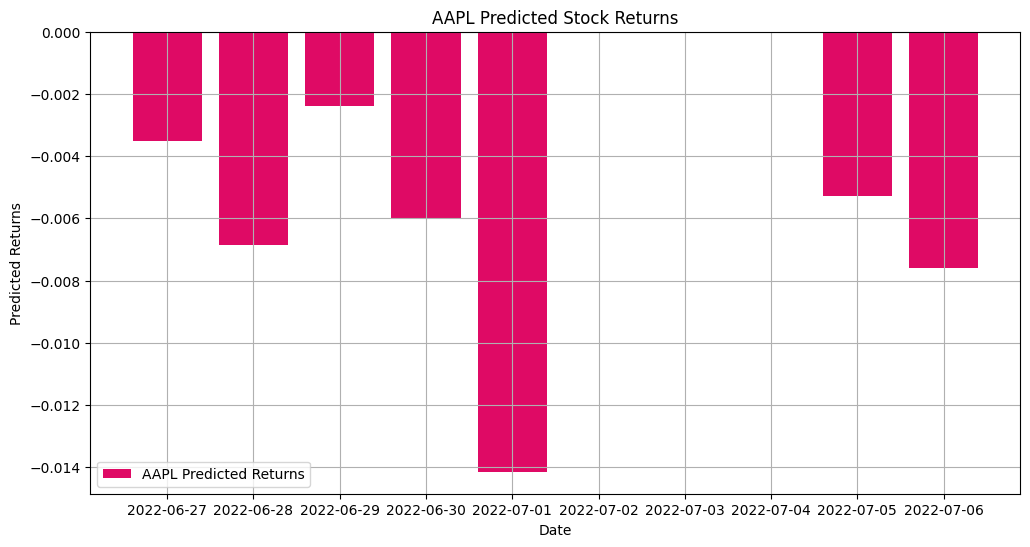

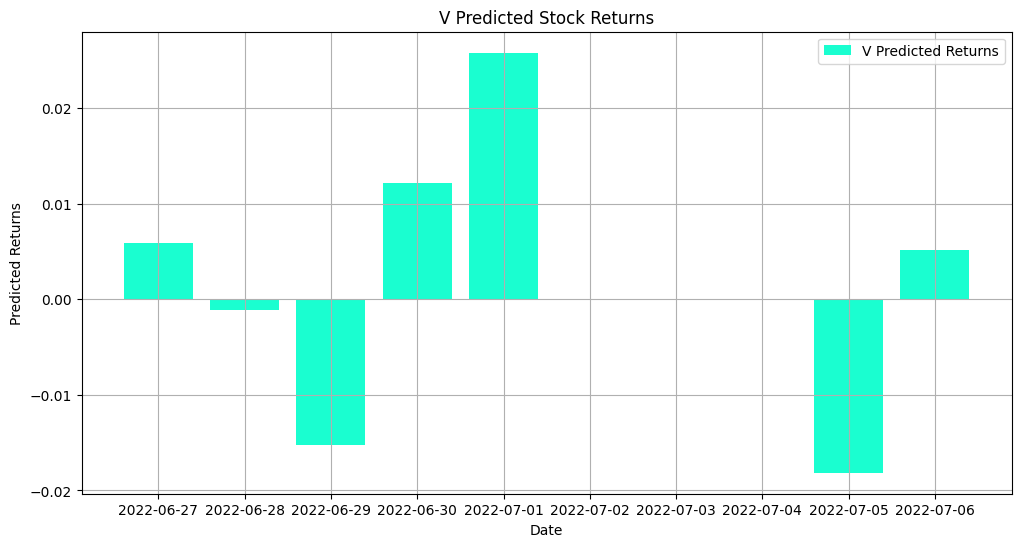

: 

: 

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        if name == 'ARIMA':
            # ARIMA initialization and fitting
            model = ARIMA(y_train, order=(5, 1, 0))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=len(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {name}")
    
    print(f"Best MSE: {best_mse}")
    
    return best_model

# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, daily_returns, stock_symbol):
    plt.figure(figsize=(12, 6))

    # Create a bar chart for predicted returns
    plt.bar(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', color=np.random.rand(3,))
    plt.title(f'{stock_symbol} Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)

# Main Function
if __name__ == "__main__":
    # Get user input for up to three stock symbols
    stock_symbols = []
    for i in range(3):
        stock_symbol = input(f"Enter stock symbol {i+1} (or press Enter to stop): ")
        if not stock_symbol:
            break
        stock_symbols.append(stock_symbol)
    
    if not stock_symbols:
        print("No stock symbols provided. Exiting.")
        exit()

    # Specify the start date and number of days to forecast
    num_days = input("Enter the number of days to forecast (1-60): ")
    end_date = input("Enter the start date (YYYY-MM-DD): ")

    # Validate the number of days
    try:
        num_days = int(num_days)
        if not (1 <= num_days <= 60):
            print("Invalid number of days. Please enter a value between 1 and 60.")
            exit()
    except ValueError:
        print("Invalid number of days. Please enter a valid number.")
        exit()

    start_date = "2000-08-01"  # You can set the end date as needed
    
    # Fetch data, train models, and visualize predictions for each stock
    for stock_symbol in stock_symbols:
        stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
        
        # Check if there is enough data for training and testing
        if len(stock_data) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        daily_returns_data = calculate_daily_returns(stock_data)
        
        # Choose the window size for SMA and EMA
        window = 20  # You can adjust this as needed
        
        stock_data = calculate_sma_ema(daily_returns_data, window)
        
        X, y = prepare_data(stock_data, num_days)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
        
        # Predict num_days in advance using the best model
        last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
        
        predicted_returns = []
        
        for i in range(num_days):
            # Predict one day ahead
            prediction = best_model.predict(last_week_data)  # Predict one day
            predicted_returns.append(prediction[0])  # Append the prediction to the list
             # Update the last_week_data for the next prediction
            new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
            last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
            last_week_data[0, -3:] = new_data_point  # Append the new prediction data
        
        # Create a range of dates for the upcoming week
        prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
        date_labels = stock_data.index[-num_days:]
        
        # Visualize predictions for each stock
        visualize_predictions(predicted_returns, date_labels, daily_returns_data['Daily_Return'][-num_days:], stock_symbol)
           # Calculate the dynamic end_date based on the start_date and num_days
        dynamic_end_date = pd.to_datetime(start_date) + BDay(num_days)
        prediction_dates = pd.date_range(start=start_date, end=dynamic_end_date, freq='B')
        
    
for stock_symbol, predicted_returns in predicted_returns_dict.items():
        plt.plot(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

plt.figure(figsize=(12, 6))
plt.bar(prediction_dates, predicted_returns, label=f'{stock_symbol} Predicted Returns', color=np.random.rand(3,))
plt.title(f'{stock_symbol} Predicted Stock Returns')
plt.xlabel('Date')
plt.ylabel('Predicted Returns')
plt.legend()
plt.grid(True)

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.00018878999665027706
[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.0011202329701449497


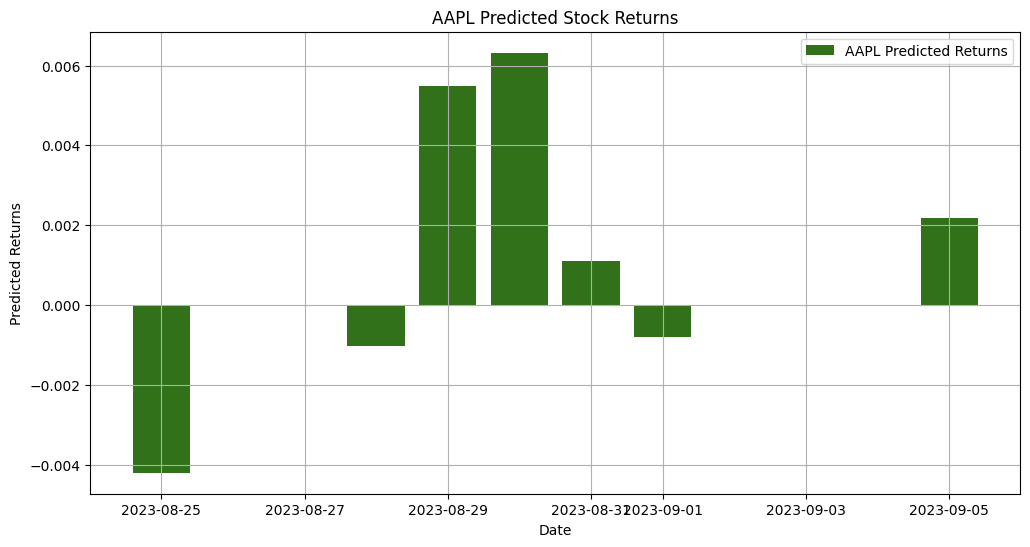

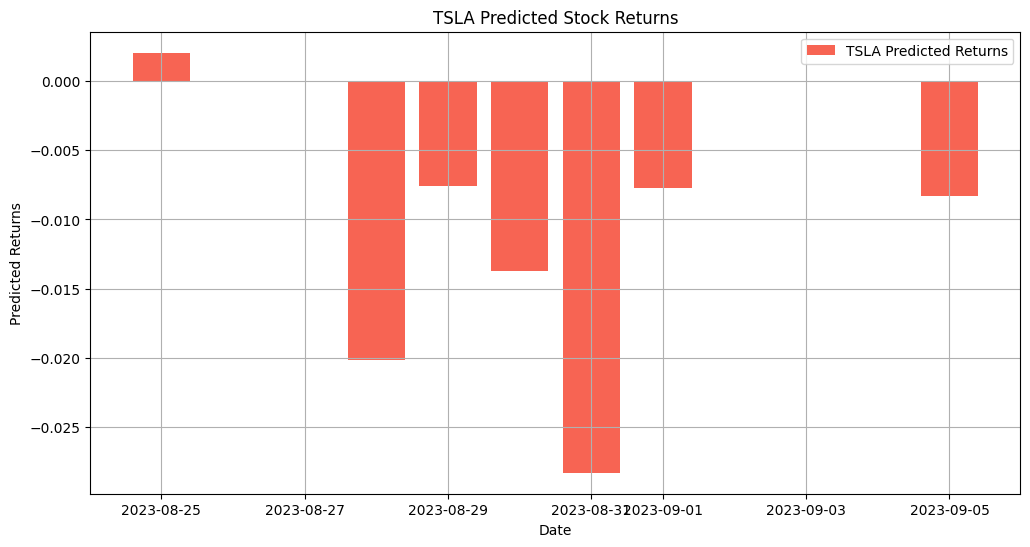

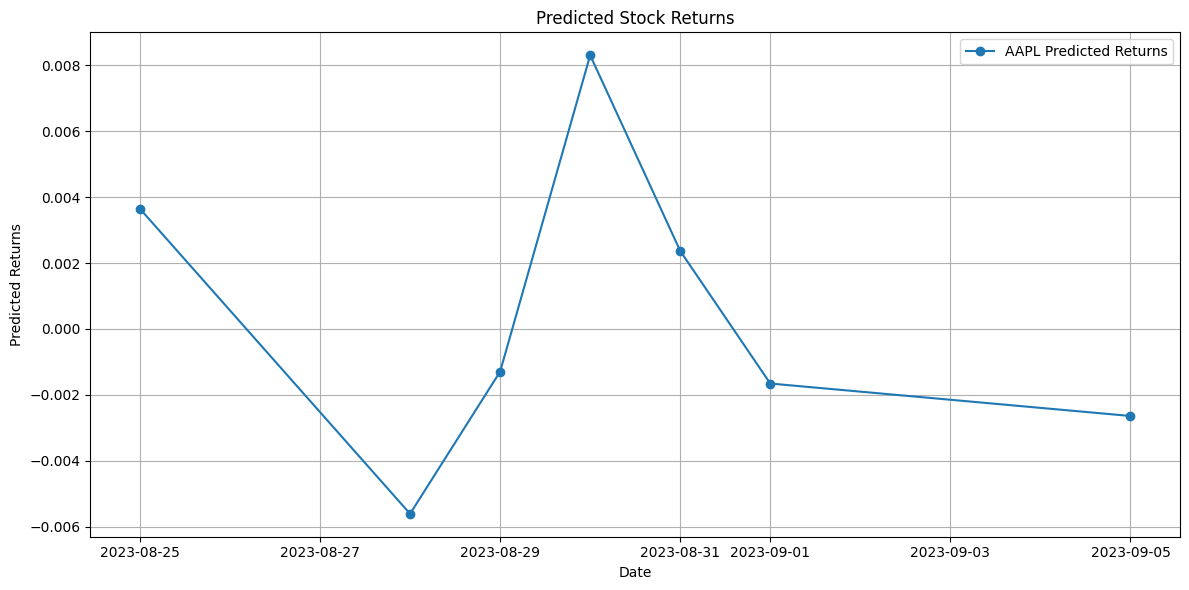

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        if name == 'ARIMA':
            # ARIMA initialization and fitting
            model = ARIMA(y_train, order=(5, 1, 0))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=len(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {name}")
    
    print(f"Best MSE: {best_mse}")
    
    return best_model

# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, daily_returns, stock_symbol):
    plt.figure(figsize=(12, 6))

    # Create a bar chart for predicted returns
    plt.bar(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', color=np.random.rand(3,))
    plt.title(f'{stock_symbol} Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)

# Main Function
if __name__ == "__main__":
    # Get user input for up to three stock symbols
    stock_symbols = []
    for i in range(3):
        stock_symbol = input(f"Enter stock symbol {i+1} (or press Enter to stop): ")
        if not stock_symbol:
            break
        stock_symbols.append(stock_symbol)
    
    if not stock_symbols:
        print("No stock symbols provided. Exiting.")
        exit()

    # Specify the start date and number of days to forecast
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    num_days = input("Enter the number of days to forecast (1-60): ")

    # Validate the number of days
    try:
        num_days = int(num_days)
        if not (1 <= num_days <= 60):
            print("Invalid number of days. Please enter a value between 1 and 60.")
            exit()
    except ValueError:
        print("Invalid number of days. Please enter a valid number.")
        exit()

    end_date = "2023-10-01"  # You can set the end date as needed
    
    # Fetch data, train models, and visualize predictions for each stock
    for stock_symbol in stock_symbols:
        stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
        
        # Check if there is enough data for training and testing
        if len(stock_data) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        daily_returns_data = calculate_daily_returns(stock_data)
        
        # Choose the window size for SMA and EMA
        window = 20  # You can adjust this as needed
        
        stock_data = calculate_sma_ema(daily_returns_data, window)
        
        X, y = prepare_data(stock_data, num_days)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
        
        # Predict num_days in advance using the best model
        last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
        
        predicted_returns = []
        
        for i in range(num_days):
            # Predict one day ahead
            prediction = best_model.predict(last_week_data)  # Predict one day
            predicted_returns.append(prediction[0])  # Append the prediction to the list
             # Update the last_week_data for the next prediction
            new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
            last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
            last_week_data[0, -3:] = new_data_point  # Append the new prediction data
        
        # Create a range of dates for the upcoming week
        prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
        date_labels = stock_data.index[-num_days:]
        
        # Visualize predictions for each stock
        visualize_predictions(predicted_returns, date_labels, daily_returns_data['Daily_Return'][-num_days:], stock_symbol)
    # Create a single line chart for predicted returns of all stocks
    plt.figure(figsize=(12, 6))
    
    for stock_symbol, predicted_returns in predicted_returns_dict.items():
        plt.plot(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

    plt.title('Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


----------------------------------------------------------------

Updated code

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.00011586292893464955


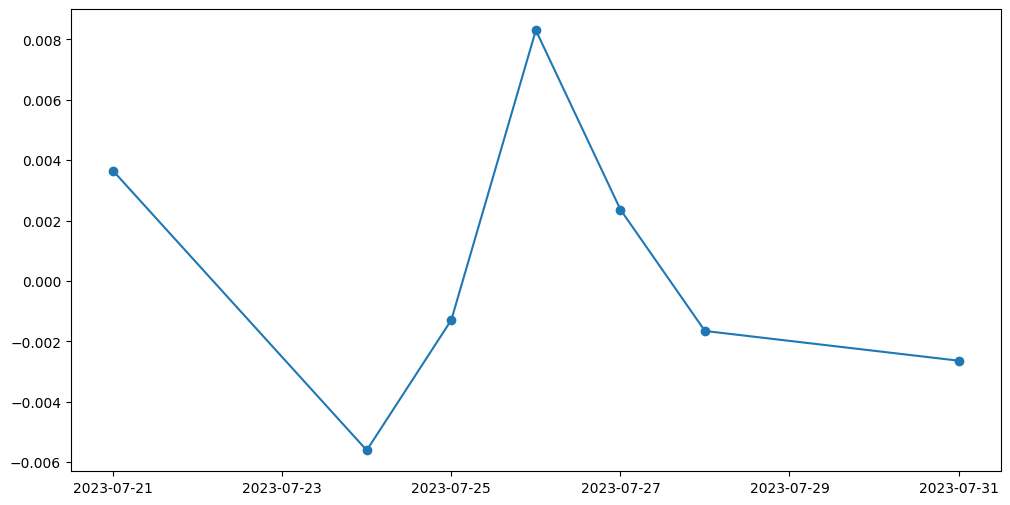

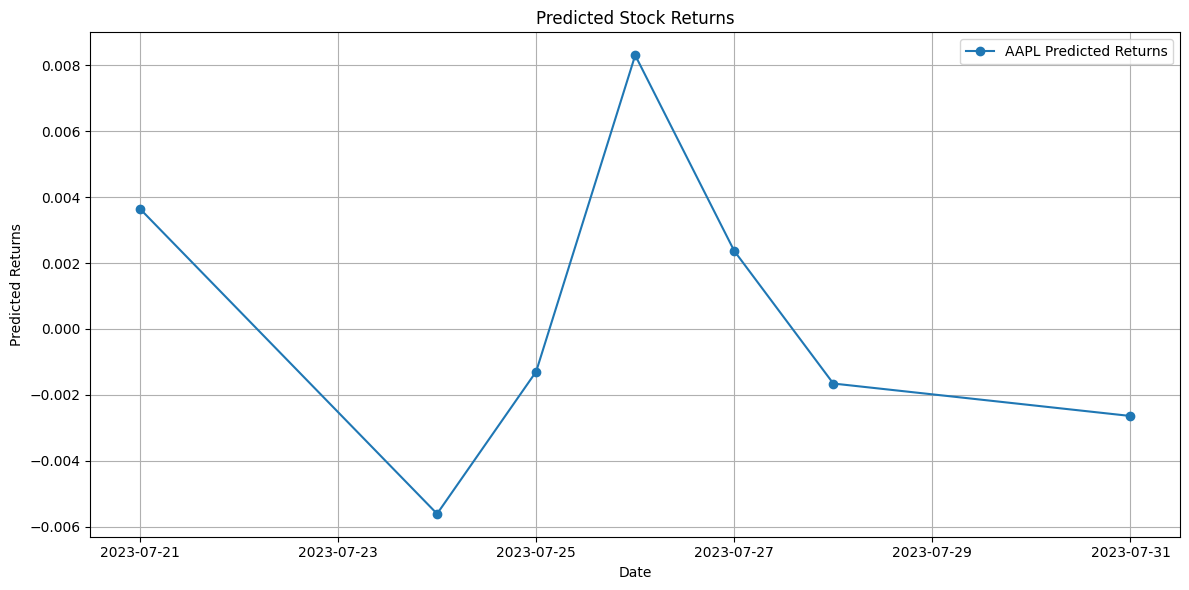

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        if name == 'ARIMA':
            # ARIMA initialization and fitting
            model = ARIMA(y_train, order=(5, 1, 0))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=len(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {name}")
    
    print(f"Best MSE: {best_mse}")
    
    return best_model

# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, daily_returns, stock_symbol):
    plt.figure(figsize=(12, 6))

    # Plot the line chart for predicted returns
    plt.plot(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

# Main Function
if __name__ == "__main__":
    # Get user input for up to three stock symbols
    stock_symbols = []
    for i in range(3):
        stock_symbol = input(f"Enter stock symbol {i+1} (or press Enter to stop): ")
        if not stock_symbol:
            break
        stock_symbols.append(stock_symbol)
    
    if not stock_symbols:
        print("No stock symbols provided. Exiting.")
        exit()

    # Specify the start date and number of days to forecast
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    num_days = input("Enter the number of days to forecast (1-60): ")

    # Validate the number of days
    try:
        num_days = int(num_days)
        if not (1 <= num_days <= 60):
            print("Invalid number of days. Please enter a value between 1 and 60.")
            exit()
    except ValueError:
        print("Invalid number of days. Please enter a valid number.")
        exit()

    end_date = "2023-08-01"  # You can set the end date as needed

    # Create a dictionary to store predicted returns for each stock
    predicted_returns_dict = {}
    
    # Fetch data, train models, and visualize predictions for each stock
    for stock_symbol in stock_symbols:
        stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
        
        # Check if there is enough data for training and testing
        if len(stock_data) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        daily_returns_data = calculate_daily_returns(stock_data)
        
        # Choose the window size for SMA and EMA
        window = 20  # You can adjust this as needed
        
        stock_data = calculate_sma_ema(daily_returns_data, window)
        
        X, y = prepare_data(stock_data, num_days)
        
        # Check if there is enough data for training and testing
        if len(X) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Check if there is enough data for training and testing
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
        
        # Predict num_days in advance using the best model
        last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
        
        predicted_returns = []
        
        for i in range(num_days):
            # Predict one day ahead
            prediction = best_model.predict(last_week_data)  # Predict one day
            predicted_returns.append(prediction[0])  # Append the prediction to the list
             # Update the last_week_data for the next prediction
            new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
            last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
            last_week_data[0, -3:] = new_data_point  # Append the new prediction data
        
        # Create a range of dates for the upcoming week
        prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
        date_labels = stock_data.index[-num_days:]
        
        # Store predicted returns in the dictionary
        predicted_returns_dict[stock_symbol] = predicted_returns
        
        # Visualize predictions for each stock
        visualize_predictions(predicted_returns, date_labels, daily_returns_data['Daily_Return'][-num_days:], stock_symbol)

    # Create a single line chart for predicted returns of all stocks
    plt.figure(figsize=(12, 6))
    
    for stock_symbol, predicted_returns in predicted_returns_dict.items():
        plt.plot(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

    plt.title('Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
